<a href="https://colab.research.google.com/github/AsmaBenHmidene/Fire-Alarm-Detection/blob/main/Fire_Alarm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # classification problem

Objective: detect fires using data from a smoke detector.

data is from the following URL:  

fpath = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTAQMDlyQdVuWy9le6OcM14fIZdQKg0s_PXhWUYIjUoB_rFpOz9Sv0K05ryiIQkTezghYtkLj6maFCW/pub?gid=2097390352&single=true&output=csv"copy
Note: this is a modified version of the original dataset from Kaggle.



In [58]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.neighbors import KNeighborsClassifier


# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [60]:

import warnings
warnings.filterwarnings('ignore')

In [61]:
filename = '/content/drive/MyDrive/Coding Dojo/ MACHINE LEARNING/Mock Belt Exams/smoke_detection_iot_BELT.csv'
df = pd.read_csv(filename)
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1655127852,19.117,56.52,400,13314.0,High,med,1.71,1.78,11.77,1.835,0.041,1928,0
1,1,1654777894,NaN,55.78,400,12889.0,Low,High,1.71,1.78,11.79,1.838,0.042,22541,1
2,2,1654785729,26.160,51.93,406,12989.0,Low,High,1.95,2.03,13.43,2.095,0.047,20717,1
3,3,1654773681,26.960,52.51,577,NaN,Low,High,2.31,2.40,15.91,2.481,0.056,22852,1
4,4,1654779348,19.860,NaN,400,12910.0,Low,High,1.72,1.79,11.85,1.848,0.042,14193,1


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62633 entries, 0 to 62632
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62633 non-null  int64  
 1   UTC             62633 non-null  int64  
 2   Temperature[C]  43843 non-null  float64
 3   Humidity[%]     51985 non-null  float64
 4   eCO2[ppm]       62633 non-null  int64  
 5   Raw H2          47602 non-null  float64
 6   Raw Ethanol     62633 non-null  object 
 7   Pressure[hPa]   62633 non-null  object 
 8   PM1.0           62633 non-null  float64
 9   PM2.5           62633 non-null  float64
 10  NC0.5           62633 non-null  float64
 11  NC1.0           62633 non-null  float64
 12  NC2.5           62633 non-null  float64
 13  CNT             62633 non-null  int64  
 14  Fire Alarm      62633 non-null  int64  
dtypes: float64(8), int64(5), object(2)
memory usage: 7.2+ MB


In [63]:
df.shape

(62633, 15)

# Cleaning data:

We will drop unnecessery columns

In [64]:
df1=df.drop(columns=['Unnamed: 0'])
df1.head()

,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1655127852,19.117,56.52,400,13314.0,High,med,1.71,1.78,11.77,1.835,0.041,1928,0
1,1654777894,NaN,55.78,400,12889.0,Low,High,1.71,1.78,11.79,1.838,0.042,22541,1
2,1654785729,26.160,51.93,406,12989.0,Low,High,1.95,2.03,13.43,2.095,0.047,20717,1
3,1654773681,26.960,52.51,577,NaN,Low,High,2.31,2.40,15.91,2.481,0.056,22852,1
4,1654779348,19.860,NaN,400,12910.0,Low,High,1.72,1.79,11.85,1.848,0.042,14193,1


1) Duplicates:

In [65]:
df1.duplicated().sum()

0

No duplicates

2) impossible values in numeric columns:

In [66]:
df1.select_dtypes('number').describe()

,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,6.263300e+04,43843.000000,51985.000000,62633.000000,47602.000000,62633.000000,62633.000000,62633.000000,62633.000000,62633.000000,62633.000000,62633.000000
mean,1.654792e+09,15.952252,48.462203,670.008398,12943.810491,100.589507,184.458999,491.440068,203.576810,80.045255,10510.883943,0.714591
std,1.100006e+05,14.361454,9.368010,1905.840671,270.421548,922.502411,1976.258689,4265.560446,2214.685955,1083.357380,7598.035549,0.451612
min,1.654712e+09,-22.010000,-60.980000,400.000000,10668.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.654743e+09,10.932000,47.530000,400.000000,12831.000000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.000000,0.000000
50%,1.654762e+09,20.124000,50.160000,400.000000,12924.000000,1.810000,1.880000,12.450000,1.943000,0.044000,9335.000000,1.000000
75%,1.654778e+09,25.415000,53.240000,438.000000,13109.000000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.000000,1.000000
max,1.655130e+09,59.930000,75.200000,60000.000000,13803.000000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


In [67]:
#df1['Humidity[%]'] = df1['Humidity[%]'].replace({'-':''},inplace=True)
#df1['Humidity[%]'].describe()
#Not working

This methode turned all the value to NaN.

In [68]:
#df1['Humidity[%]'] = df1['Humidity[%]'].abs()
#Not working

No change in the column.

In [69]:
df1['Humidity[%]']=df1['Humidity[%]'].astype('str')

In [70]:
df1['Humidity[%]']=df1['Humidity[%]'].str.replace('-','')

In [71]:
df1['Humidity[%]']=df1['Humidity[%]'].astype('float')

In [72]:
df1['Humidity[%]'].describe()

count    51985.000000
mean        48.559106
std          8.851991
min         10.740000
25%         47.540000
50%         50.160000
75%         53.250000
max         75.200000
Name: Humidity[%], dtype: float64

3) inconsistent values in categorical columns:

In [73]:
df1['Raw Ethanol'].unique()

array(['High', 'Low', 'Medium', 'low', 'Very Low', 'high', 'medium',
       'very low'], dtype=object)

In [74]:
df1['Raw Ethanol'] = df1['Raw Ethanol'].replace('high', 'High').replace('low', 'Low').replace('medium', 'Medium').replace('very low', 'Very Low')
df1['Raw Ethanol'].value_counts()

Low         35022
Medium      16898
High         8879
Very Low     1834
Name: Raw Ethanol, dtype: int64

In [75]:
df1['Pressure[hPa]'].unique()

array(['med', 'High', 'high', 'Low', 'Med', 'low'], dtype=object)

In [76]:
df1['Pressure[hPa]'] = df1['Pressure[hPa]'].replace('high', 'High').replace('low', 'Low').replace('med', 'Med')
df1['Pressure[hPa]'].value_counts()

High    49991
Med     11488
Low      1154
Name: Pressure[hPa], dtype: int64

4) NaN values:

In [77]:
df1.isna().sum()

UTC                   0
Temperature[C]    18790
Humidity[%]       10648
eCO2[ppm]             0
Raw H2            15031
Raw Ethanol           0
Pressure[hPa]         0
PM1.0                 0
PM2.5                 0
NC0.5                 0
NC1.0                 0
NC2.5                 0
CNT                   0
Fire Alarm            0
dtype: int64

There are missing value in Temperature[C] , Humidity [%] , Raw H2 columns. All of them are numerical columns.

We will use Exploratory Visualizations to determine the best imputation method for the numerical columns.

In [78]:
def plot_numeric(df,col):
  """EDA function to plot a histogram and boxplot for the selected column"""
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  sns.histplot(data=df,x = col,ax = axes[0])
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--',
           label=f"Mean Value = {mean_value:,.2f}",);

  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--',
           label=f"Median Value = {med_value:,.2f}");

  axes[0].legend();

  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph
  axes[0].set_title(f'EDA for {col}')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()

Temperature[C]

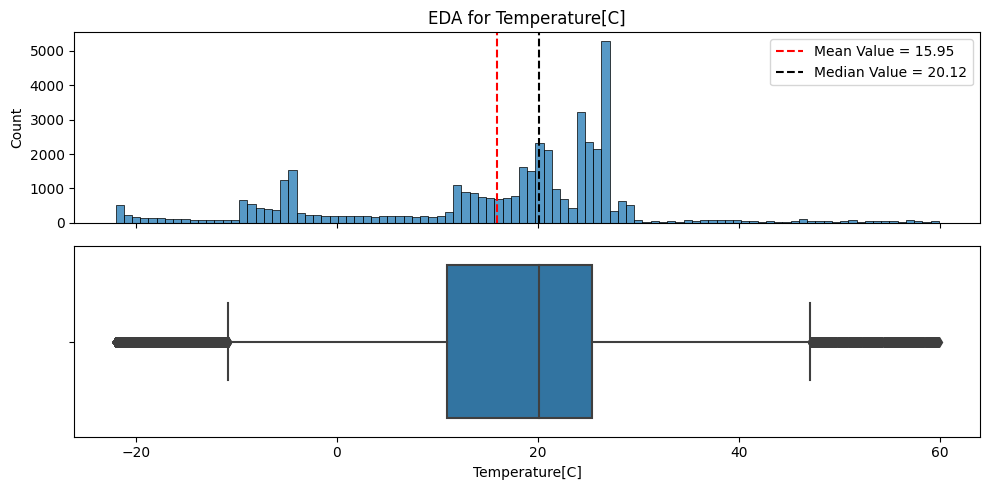

In [79]:
plot_numeric(df1,"Temperature[C]")

The distribution is skewed, therefore the missing value will be imputed with the median since the median will be less sensitive to outliers than the mean.

In [80]:
df1['Temperature[C]'].fillna(df['Temperature[C]'].median(), inplace = True)
df1['Temperature[C]'].isna().sum()

0

Humidity [%]

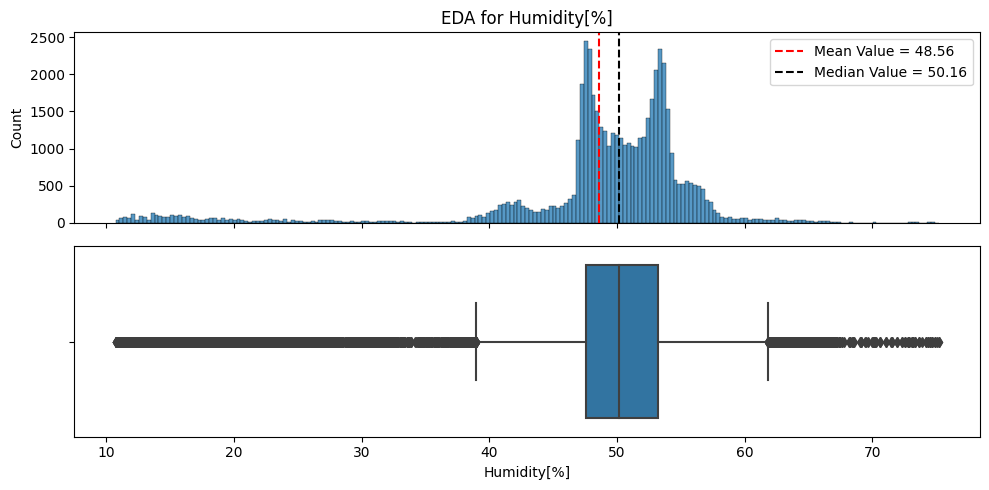

In [81]:
plot_numeric(df1,"Humidity[%]")

The distribution is symetric bimodal, therefore the missing value will be imputed with the mean.

In [82]:
df1['Humidity[%]'].fillna(df['Humidity[%]'].mean(), inplace = True)
df1['Humidity[%]'].isna().sum()

0

Raw H2

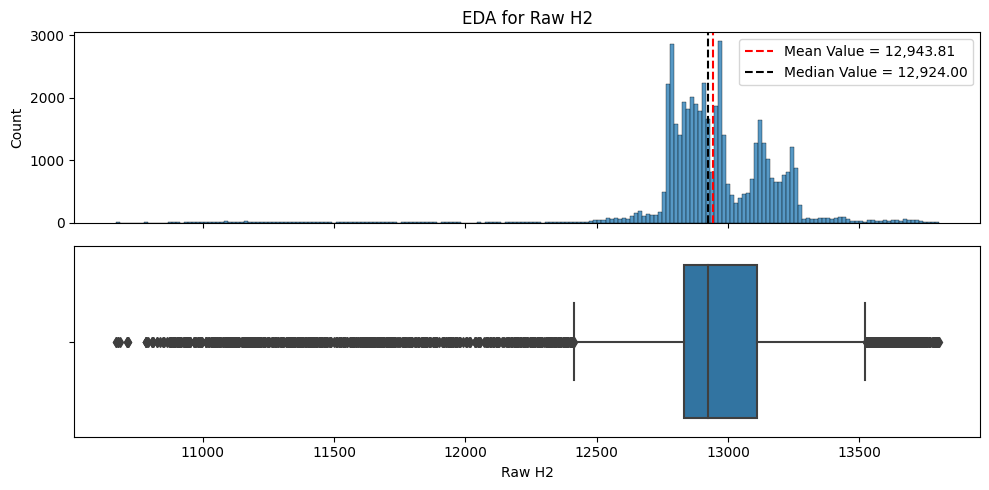

In [83]:
plot_numeric(df1,"Raw H2")

The distribution is skewed, therefore the missing value will be imputed with the median since the median will be less sensitive to outliers than the mean.

In [84]:
df1['Raw H2'].fillna(df['Raw H2'].median(), inplace = True)
df1['Raw H2'].isna().sum()

0

4) data types:

In [85]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62633 entries, 0 to 62632
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62633 non-null  int64  
 1   Temperature[C]  62633 non-null  float64
 2   Humidity[%]     62633 non-null  float64
 3   eCO2[ppm]       62633 non-null  int64  
 4   Raw H2          62633 non-null  float64
 5   Raw Ethanol     62633 non-null  object 
 6   Pressure[hPa]   62633 non-null  object 
 7   PM1.0           62633 non-null  float64
 8   PM2.5           62633 non-null  float64
 9   NC0.5           62633 non-null  float64
 10  NC1.0           62633 non-null  float64
 11  NC2.5           62633 non-null  float64
 12  CNT             62633 non-null  int64  
 13  Fire Alarm      62633 non-null  int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 6.7+ MB


6) Check Target Balance:

In [86]:
df1['Fire Alarm'].value_counts()

1    44757
0    17876
Name: Fire Alarm, dtype: int64

data fairly balanced

# Exploratory Visuals & Analysis:

## Numerical colums:

(12.5, -0.5)

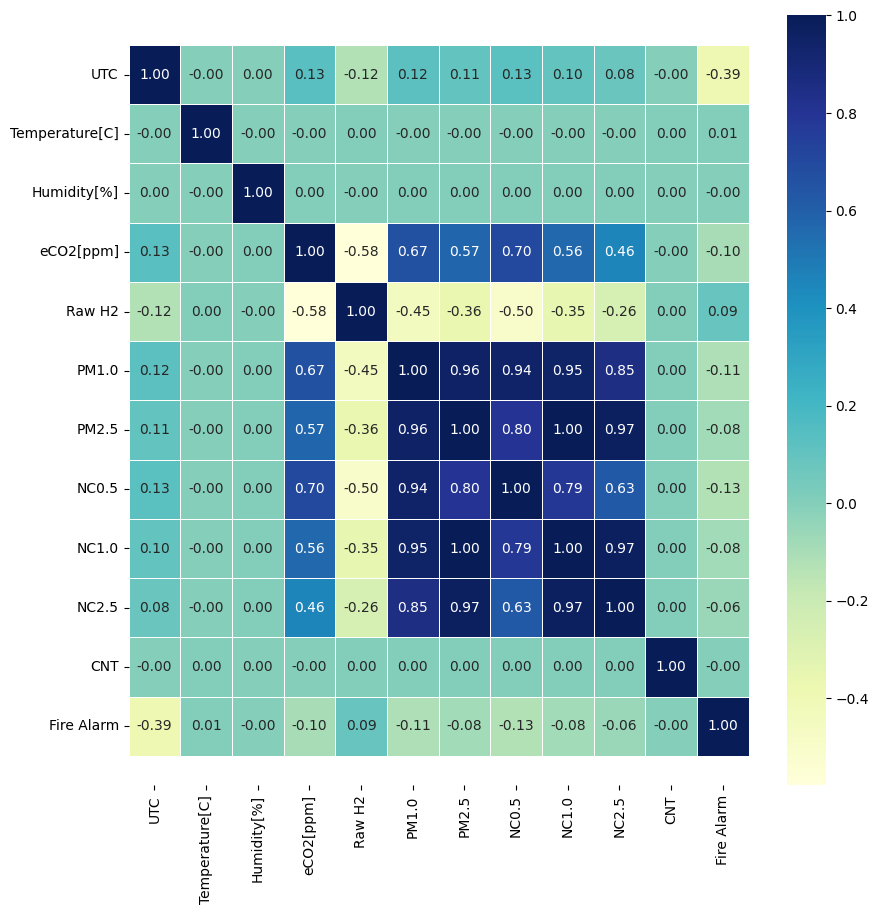

In [87]:
corr_matrix = df1.corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

- Some features such as PM1.0, PM2.5, NC1.0, NC0.5 and NC2.5 show strong positive correlation between them.
- We observe also that Temparature and humidity no correlation with the other features.

We will take a closer look to the correlation of features with the target:

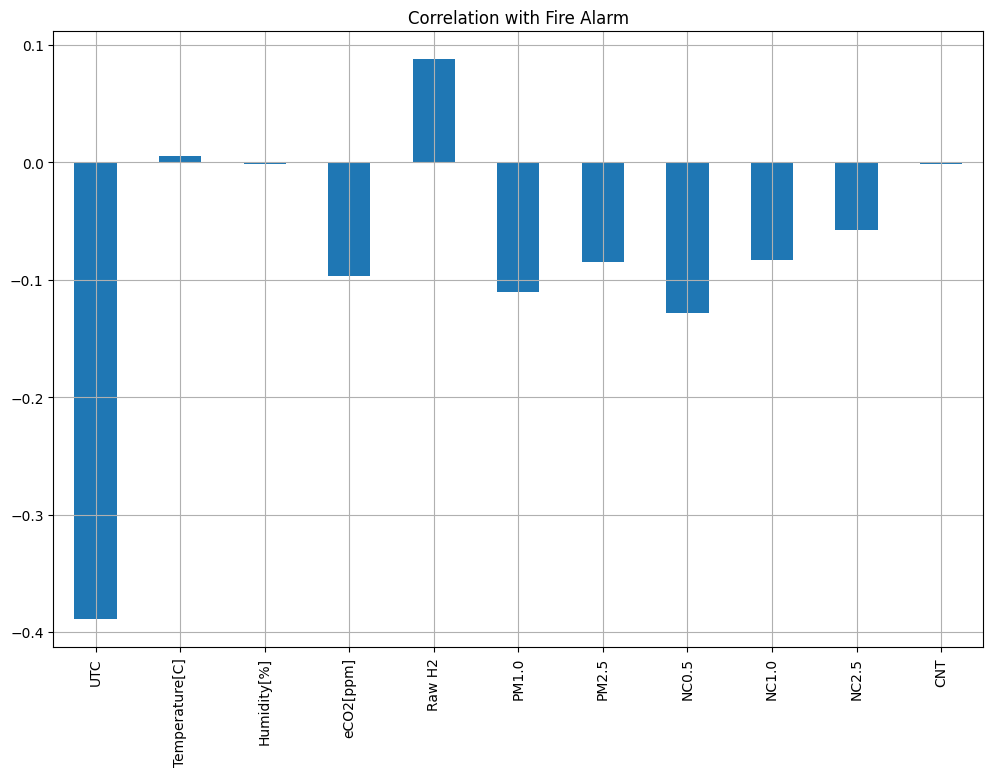

In [88]:
df1.drop('Fire Alarm', axis=1).corrwith(df1['Fire Alarm']).plot(kind='bar', grid=True, figsize=(12, 8),title="Correlation with Fire Alarm");

Observations from correlation:

CNT, Temparature and Humidity are the least correlated with the target variable(Fire Alarm). All other variables have a low negative correlation with the target variable, except for Raw H2 which has a very low positive correlation.

## Categorical colums:

In [89]:
def plot_bar(data,x, y, figsize=(10,5)):
    ## Make a larger fig/ax before plotting
    fig, ax = plt.subplots(figsize=figsize)

    ## Plot barplot

    counts = df1[x].value_counts().sort_values(ascending=False).to_frame()
    ## ploting the barplot

    sns.barplot(data=counts,x=counts.index, y = counts[x],ax=ax)

    plt.xticks(rotation= 90)
    ax.set_title(f'Categorical Frequencies of {y}', fontsize = 20, fontweight = 'bold');
    ax.set_xlabel(f'Categories for {y}', fontsize = 15, fontweight = 'bold')
    ax.set_ylabel('Counts', fontsize = 15, fontweight = 'bold')

    return fig,ax

Low         35022
Medium      16898
High         8879
Very Low     1834
Name: Raw Ethanol, dtype: int64


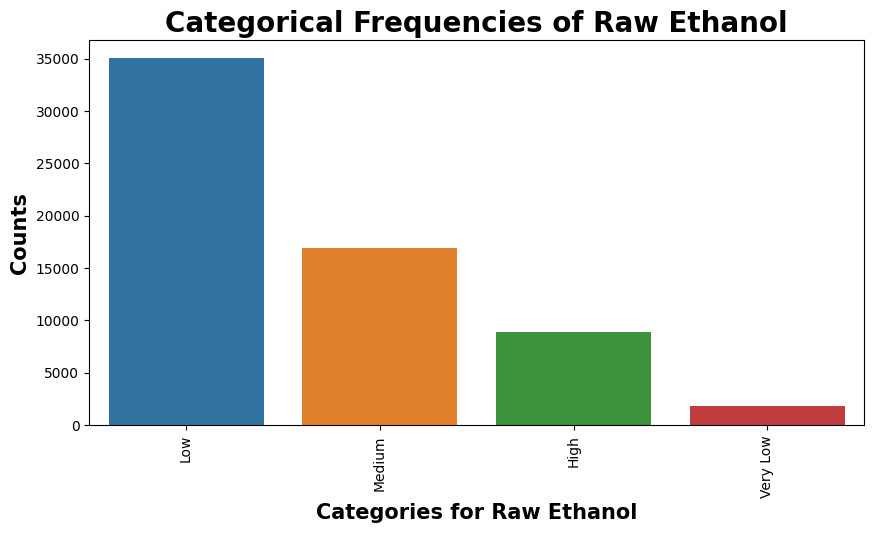

In [90]:
fig, ax = plot_bar(df1, 'Raw Ethanol', 'Raw Ethanol');
print(df1['Raw Ethanol'].value_counts())

The most fraquent raw ethanol level in our data is low level while very low level is the least frequent one.

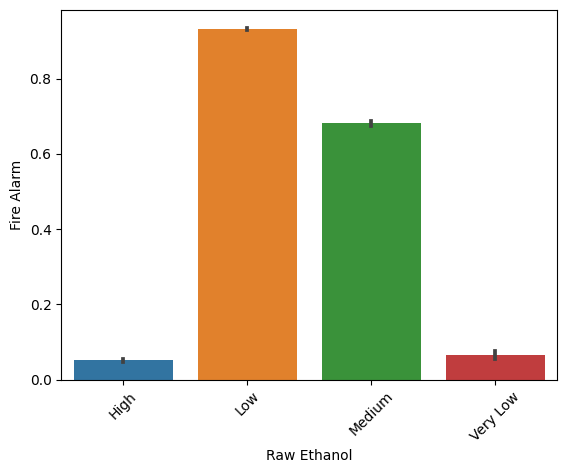

In [91]:
sns.barplot(data=df1, x='Raw Ethanol', y="Fire Alarm");
plt.xticks(rotation = 45);
plt.ylabel('Fire Alarm')
plt.xlabel('Raw Ethanol');

This barplot shows that in most cases the alarm is on at a low leval of ethanol.

High    49991
Med     11488
Low      1154
Name: Pressure[hPa], dtype: int64


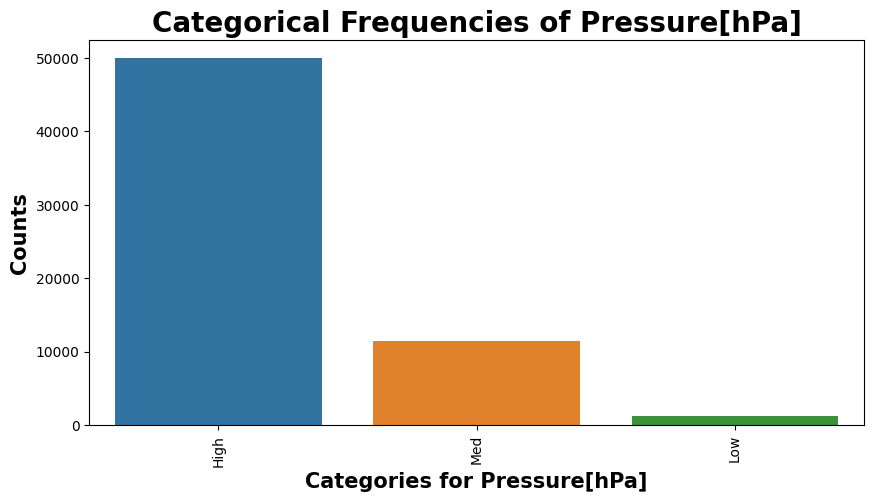

In [92]:
fig, ax = plot_bar(df1, 'Pressure[hPa]', 'Pressure[hPa]');
print(df1['Pressure[hPa]'].value_counts())

The most fraquent pressure level in our data is high level while low level is the least frequent one.

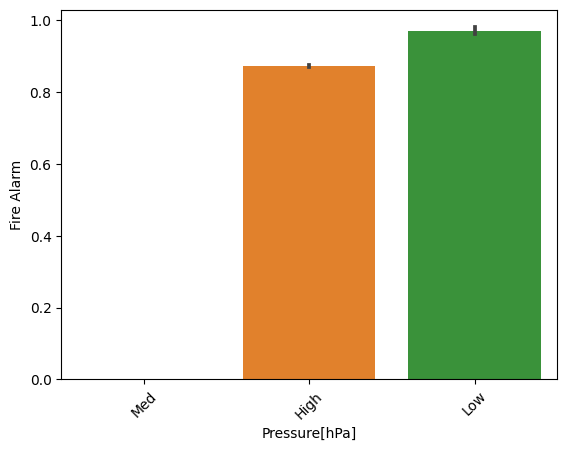

In [93]:
sns.barplot(data=df1, x='Pressure[hPa]', y="Fire Alarm");
plt.xticks(rotation = 45);
plt.ylabel('Fire Alarm')
plt.xlabel('Pressure[hPa]');

This barplot shows that in most cases the alarm is on at a low pressure level.

# Pre-processing:

In [94]:
#Identify the features (X) and target (y)
y = df1['Fire Alarm']
X = df1.drop(columns=['Fire Alarm'])

In [95]:
#Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.head()

,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
10827,1654717905,17.480,43.940000,400,13748.0,High,Med,0.64,0.67,4.43,0.691,0.016,22466
49249,1654754961,27.120,48.100000,400,12924.0,Low,High,2.23,2.31,15.32,2.390,0.054,21164
42347,1654712700,-21.664,37.060000,400,12924.0,High,Med,2.00,2.08,13.79,2.150,0.049,8309
12340,1654775833,26.680,41.260000,468,12924.0,Low,High,2.16,2.24,14.84,2.315,0.052,4419
19545,1655129442,16.825,48.462203,17365,11012.0,Very Low,Med,7745.31,16075.88,33135.25,17914.934,7981.223,21012


numerical columns:

In [96]:
#Create list of column names for numeric columns
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
scaler = StandardScaler()

Numeric Columns: Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')


In [97]:
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', scaler, num_cols)
num_tuple

('numeric',
 StandardScaler(),
 Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
        'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
       dtype='object'))

Object columns: Both columns are Ordinal features

In [98]:
obj_cols = X_train.select_dtypes("object").columns
print("Object Columns:", obj_cols)

Object Columns: Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object')


In [99]:
ordinal_cols = ['Raw Ethanol', 'Pressure[hPa]']

In [100]:
qual_cond_order_ethanol = ['High','Medium', 'Low', 'Very Low']
qual_cond_order_pressure = ['High','Med', 'Low']

In [101]:
ordinal_category_orders = [qual_cond_order_ethanol, qual_cond_order_pressure]

In [102]:
# instantiate preprocessors
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
ord_pipe = make_pipeline(ord_encoder, scaler)
ord_pipe

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['High', 'Medium', 'Low',
                                             'Very Low'],
                                            ['High', 'Med', 'Low']])),
                ('standardscaler', StandardScaler())])

In [103]:
# Making a numeric tuple for ColumnTransformer
ord_tuple = ('ordinalFeature', ord_pipe, obj_cols)
ord_tuple

('ordinalFeature',
 Pipeline(steps=[('ordinalencoder',
                  OrdinalEncoder(categories=[['High', 'Medium', 'Low',
                                              'Very Low'],
                                             ['High', 'Med', 'Low']])),
                 ('standardscaler', StandardScaler())]),
 Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))

In [104]:
#Instantiate the ColumnTransformer
col_transformer = ColumnTransformer([num_tuple, ord_tuple],remainder='passthrough',verbose_feature_names_out=False)

In [105]:
#Fit the Transformer on Training Data Only
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric', StandardScaler(),
                                 Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                ('ordinalFeature',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['High',
                                                                              'Medium',
                                                                              'Low',
                                                                              'Very '
                                                                              'Low'],
                                                                             ['High',
                                                                              'Med',
                                                                              'Low']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                  verbose_feature_names_out=False)

In [106]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)
# Transform the testing data
X_test_processed = col_transformer.transform(X_test)
# View the processed training data
X_train_processed.head()

,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Raw Ethanol,Pressure[hPa]
10827,-0.674043,0.024411,-0.567688,-0.140951,3.433185,-0.106960,-0.091255,-0.113265,-0.089868,-0.072496,1.571754,-1.921513,1.709152
49249,-0.336618,0.815272,-0.052954,-0.140951,-0.063858,-0.105212,-0.090427,-0.110640,-0.089103,-0.072461,1.400573,0.680985,-0.481334
42347,-0.721439,-3.186945,-1.418979,-0.140951,-0.063858,-0.105465,-0.090543,-0.111009,-0.089211,-0.072466,-0.289543,-1.921513,1.709152
12340,-0.146561,0.779174,-0.899296,-0.104893,-0.063858,-0.105289,-0.090462,-0.110755,-0.089137,-0.072463,-0.800982,0.680985,-0.481334
19545,3.073342,-0.029325,-0.008137,8.855088,-8.178354,8.407414,8.032079,7.873951,7.979784,7.202255,1.380589,1.982235,1.709152


# Models to predict Fire Alarm:

In [107]:
def evaluate_model(model_pipe, X_train, y_train, X_test, y_test):
  # Get predictions
  y_pred_train = model_pipe.predict(X_train)
  y_pred_test = model_pipe.predict(X_test)

  # Accuracy
  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  print(f'Training accuracy: {train_accuracy:.2f}')
  print(f'Test accuracy: {test_accuracy:.2f}')
  print()

  # Precision
  train_precision = precision_score(y_train, y_pred_train)
  test_precision = precision_score(y_test, y_pred_test)

  print(f'Training precision: {train_precision:.2f}')
  print(f'Test precision: {test_precision:.2f}')
  print()


  # Recall
  train_recall = recall_score(y_train, y_pred_train)
  test_recall = recall_score(y_test, y_pred_test)

  print(f'Training Recall: {train_recall:.2f}')
  print(f'Test Recall: {test_recall:.2f}')
  print()


  # roc_auc
  y_pred_proba_train = model_pipe.predict_proba(X_train)
  y_pred_proba_test = model_pipe.predict_proba(X_test)
  train_roc_auc = roc_auc_score(y_train, y_pred_proba_train[:,1])
  test_roc_auc = roc_auc_score(y_test, y_pred_proba_test[:,1])

  print(f'Training ROC AUC: {train_roc_auc:.2f}')
  print(f'Test ROC AUC: {test_roc_auc:.2f}')
  print()

  # Make figure for training and test conf matrix
  fig, axes = plt.subplots(ncols=2, figsize=(8,4))

  ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, normalize='true',
                                          cmap='Greens', ax=axes[0])
  axes[0].set_title("Training Data")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true',
                                          cmap='Reds', ax=axes[1])
  axes[1].set_title("Test Data")

  fig.suptitle("Confusion Matrices")
  fig.tight_layout()
  plt.show()



  # Make figure for training and test conf matrix
  fig, axes = plt.subplots(ncols=2, figsize=(8,4))

  # Visualize the ROC curve
  RocCurveDisplay.from_estimator(model_pipe, X_train, y_train, ax=axes[0])
  axes[0].plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  axes[0].legend();
  axes[0].set_title("Training Data")

  RocCurveDisplay.from_estimator(model_pipe, X_test, y_test, ax=axes[1])
  axes[1].plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  axes[1].legend();
  axes[1].set_title("Test Data")

  fig.suptitle('ROC Curves')
  fig.tight_layout()
  plt.show()

## 1) Logistic Regression:

Training accuracy: 0.85
Test accuracy: 0.86

Training precision: 0.84
Test precision: 0.85

Training Recall: 0.98
Test Recall: 0.98

Training ROC AUC: 0.89
Test ROC AUC: 0.90



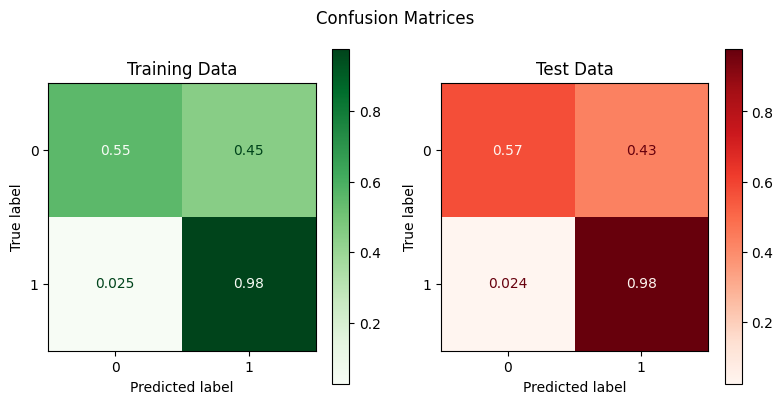

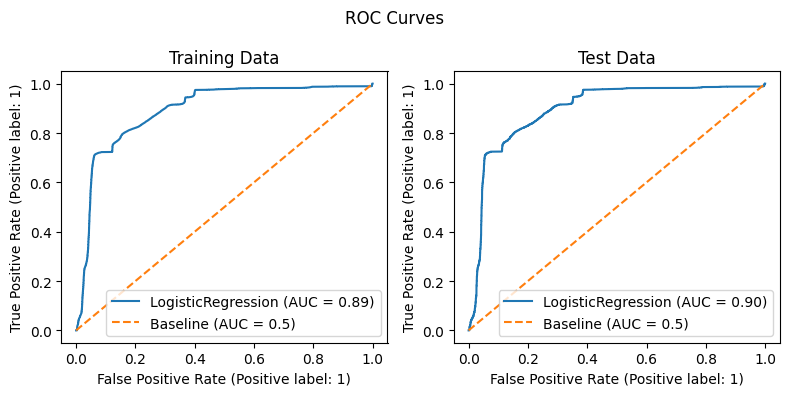

In [108]:
logreg = LogisticRegression()

logreg.fit(X_train_processed,y_train)

evaluate_model(logreg, X_train_processed, y_train, X_test_processed, y_test)

### Tuning:

In [109]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [110]:
model = LogisticRegression()

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty':['l1', 'l2'], 'solver': ['liblinear','saga']},

In [111]:
dt_grid_search = GridSearchCV(model, param_grid)

In [112]:
dt_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=({'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']},))

In [113]:
dt_grid_search.best_params_

{'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}

### Best model evalution:

In [114]:
best_model = dt_grid_search.best_estimator_

Training accuracy: 0.86
Test accuracy: 0.87

Training precision: 0.86
Test precision: 0.86

Training Recall: 0.97
Test Recall: 0.98

Training ROC AUC: 0.88
Test ROC AUC: 0.89



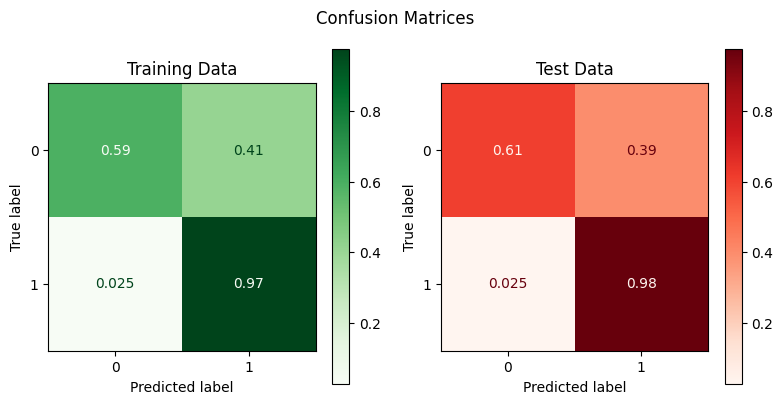

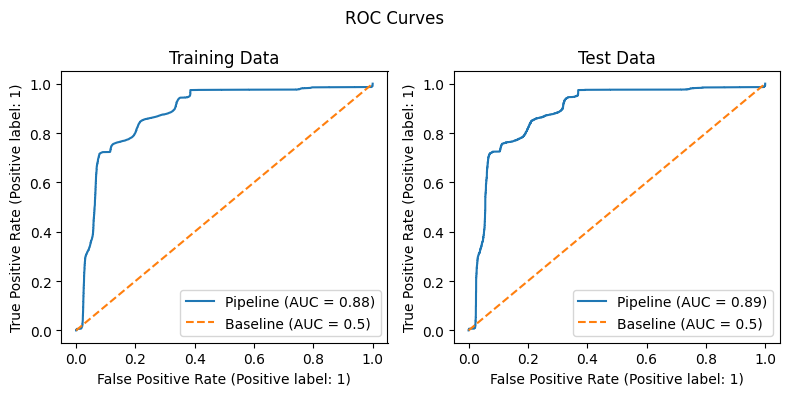

In [115]:
logreg_pipe1 = make_pipeline(best_model)

logreg_pipe1.fit(X_train_processed,y_train)

evaluate_model(logreg_pipe1, X_train_processed, y_train, X_test_processed, y_test)

Training metrics and testing metrics are almost equal. no undefit or overfit problem.

## 2) k-nearest neighbors:

Training accuracy: 1.00
Test accuracy: 0.90

Training precision: 1.00
Test precision: 0.93

Training Recall: 1.00
Test Recall: 0.94

Training ROC AUC: 1.00
Test ROC AUC: 0.87



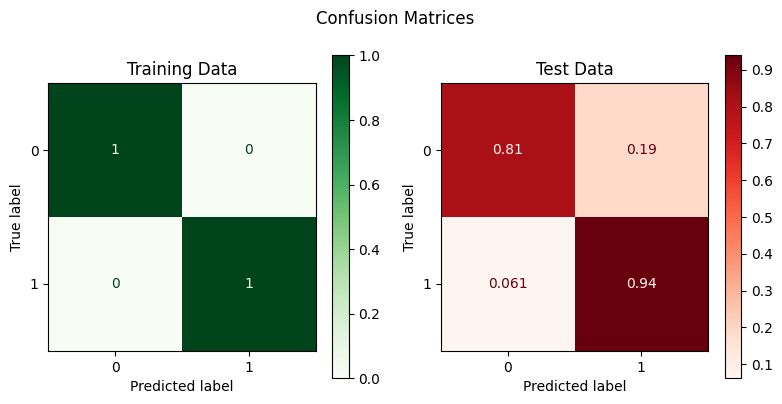

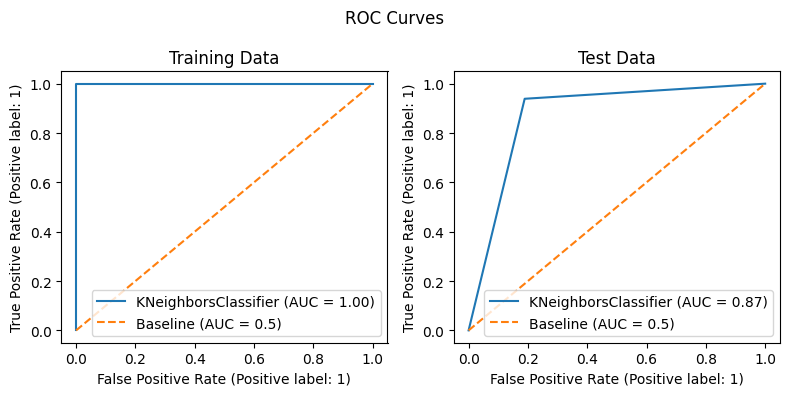

In [116]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_processed,y_train)

evaluate_model(knn, X_train_processed, y_train, X_test_processed, y_test)

### Tuning:

In [117]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [118]:
model = KNeighborsClassifier()

param_grid = {'n_neighbors': [3,5,6,7,8,10], 'weights':['uniform', 'distance'], 'leaf_size': [2,3,4,5,10]},

In [119]:
dt_grid_search = GridSearchCV(model, param_grid)

In [120]:
dt_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=({'leaf_size': [2, 3, 4, 5, 10],
                          'n_neighbors': [3, 5, 6, 7, 8, 10],
                          'weights': ['uniform', 'distance']},))

In [121]:
dt_grid_search.best_params_

{'leaf_size': 2, 'n_neighbors': 10, 'weights': 'distance'}

### Best model evalution:

In [122]:
best_model_knn = dt_grid_search.best_estimator_

Training accuracy: 1.00
Test accuracy: 0.91

Training precision: 1.00
Test precision: 0.91

Training Recall: 1.00
Test Recall: 0.98

Training ROC AUC: 1.00
Test ROC AUC: 0.95



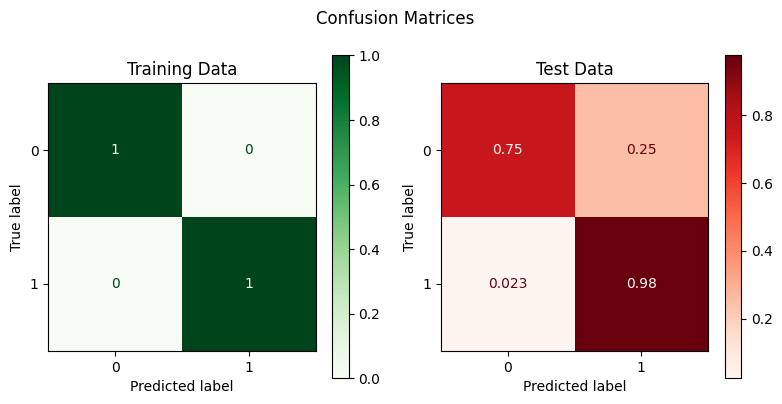

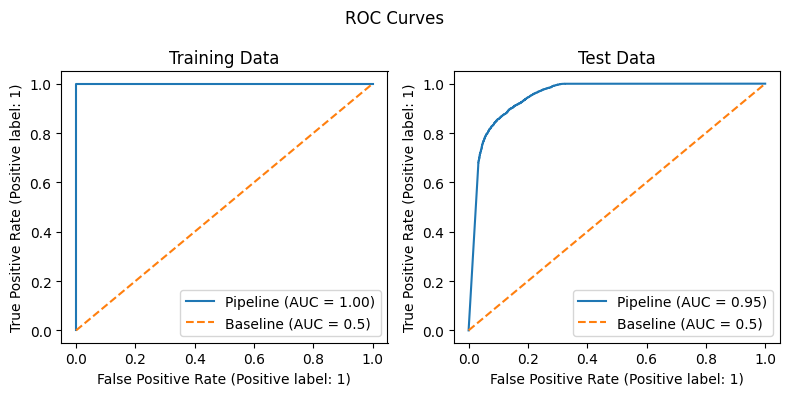

In [123]:
knn_pipe = make_pipeline(best_model_knn)

knn_pipe.fit(X_train_processed,y_train)

evaluate_model(knn_pipe, X_train_processed, y_train, X_test_processed, y_test)

- What do 'false positives' and 'false negatives' mean for this problem? Which is worse?
 - 'false positives'= there is no fire but the alarm is ON.
 - 'false negatives'= There is fire but the alarm is Off.
- Which of your models would you recommend for production? Which metric or metrics did you use to decide that, and why?
 - Tuned k-nearest neighbors Model is the recommended model for fire detection:
   - it is accurancy (0.91) is better than the one of Tuned Logistic Regression (0.87)
   - metrics recall and precision are important in this case.
A higher recall means fewer false negative predictions, also known as type 2 errors, which mean a lower risk that the alarm is off when actualy there is a fire and a high precision means fewer type 1 errors, or fewer false positives, which mean a lower risk to turn on the alarm while there is no fire.
   - in the Tuned k-nearest neighbors Model, testing recall is 0.98 and testing precision is 0.91, which is a better result than the one obtained from the other model(Vs recall=0.99 and precision=0.86 for tuned logistic regression).
   - Also the Confusion Matrix shows that:
     - False negative in Tuned k-nearest neighbors Model is equal to 2,3% while in the other model, it is equal to 2,5% which is slightly better but important because it is dangerous to actualy have a fire but the alarm is predicted to be Off.
     - Tuned k-nearest neighbors Model can predec
   - ROC curves show that Tuned k-nearest neighbors Model indicate a better performance. The AUC value is also higher (AUC= 0.95) than the other model (AUC = 0.89) confirming that Tuned k-nearest neighbors model is more efficient.